In [1]:
import numpy as np 
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import sys
import os
import ast
sys.path.insert(0, os.path.abspath('..'))

#from Clustering_Functions import *
from Clustering_Analysis_Functions import *
import itertools
import os
import pickle
import warnings
import math
from matplotlib.ticker import MaxNLocator
from sklearn.manifold import MDS
import joblib

warnings.filterwarnings("ignore", category=DeprecationWarning)

In [5]:
# Bypass the next sections by reading its output from a file
# df = pd.read_pickle('all_IP_results.pkl')

def decode(obj):
    if isinstance(obj, dict) and "__type__" in obj:
        if obj["__type__"] == "tuple":
            return tuple(decode(x) for x in obj["items"])
    if isinstance(obj, dict):
        return {k: decode(v) for k, v in obj.items()}
    if isinstance(obj, list):
        return [decode(v) for v in obj]
    return obj

df = (
    pd.read_json("all_IP_results_encoded.json", orient="table")
      .map(decode)
)

In [6]:
df

,filename,num_cands,k,method,proxy,technique,centers,proxies_of_centers,score,smallest_cluster_size
0,eilean_siar_2022_ward3.csv,3,1,all,Borda,all_Borda,"((2, 3, 1),)","([0, 2, 1],)",677.000000,1.0
1,eilean_siar_2022_ward4.csv,3,1,all,Borda,all_Borda,"((2, 1, 3),)","([1, 2, 0],)",701.000000,1.0
2,aberdeen_2017_ward11.csv,4,1,all,Borda,all_Borda,"((4,),)","([0, 0, 0, 3],)",12913.500000,1.0
3,aberdeenshire_2017_ward1.csv,4,1,all,Borda,all_Borda,"((3, 1, 4, 2),)","([2, 0, 3, 1],)",9453.500000,1.0
4,aberdeenshire_2017_ward16.csv,4,1,all,Borda,all_Borda,"((4, 1),)","([2, 0, 0, 3],)",8571.000000,1.0
...,...,...,...,...,...,...,...,...,...,...
19105,glasgow_2012_ward13.csv,13,1,Lloyd,HH,Lloyd_HH,"((1, 9, 6, 4, 13, 10, 5, 11, 7, 2, 3, 8, 12),)","([0.6236598441, 0.6254873294000001, 0.28301656...",19526.721823,1.0
19106,glasgow_2012_ward9.csv,13,1,Lloyd,Borda,Lloyd_Borda,"((9, 6, 13, 2, 10, 7, 11, 5, 4, 12, 1, 8, 3),)","([0.6773485514, 4.1755926251, 0.30728709390000...",30711.225530,1.0
19107,glasgow_2012_ward9.csv,13,1,Lloyd,HH,Lloyd_HH,"((9, 6, 13, 2, 10, 7, 11, 5, 12, 4, 8, 1, 3),)","([-0.321334504, 0.033362598800000004, -0.01273...",10430.070862,1.0
19108,glasgow_2012_ward5.csv,14,1,Lloyd,Borda,Lloyd_Borda,"((1, 9, 13, 10, 11, 5, 7, 4, 3, 12, 14, 8, 6, ...","([5.6347487002, 0.6275274408, 1.7154823801, 2....",58877.629936,1.0


In [2]:
dfK = pd.read_pickle('../clustering_results.pkl') # heuristic results
dfIP = pd.read_csv("cluster_centers_summary.csv")

In [3]:
print(list(dfK.columns))
print(list(dfIP.columns))

['filename', 'num_cands', 'parties', 'method', 'sil', 'cal', 'dav', 'centers', 'bloc size']
['n_clusters', 'method', 'proxy', 'n_candidates', 'election_file', 'centers']


In [4]:
dfIP['method'].unique(), dfIP['proxy'].unique(), dfIP['n_clusters'].unique()

(array(['all_ballot', 'cast_ballot', 'coordinate'], dtype=object),
 array(['borda', 'head_to_head'], dtype=object),
 array([1, 2]))

In [7]:
print(dfIP['method'].unique())
print(dfK['method'].unique())

['all_ballot' 'cast_ballot' 'coordinate']
['Lloyd_Bp' 'Lloyd_Ba' 'Lloyd_H' 'PAM_Bp' 'PAM_Ba' 'PAM_H' 'slate']


In [8]:
# create `df` dataframe to hold IP and heuristic results.

df = pd.DataFrame(columns=['filename', 'num_cands', 'k', 'method', 'proxy', 'technique', 
                           'centers', 'proxies_of_centers'])

# add the IP results to df.
D_IP_proxy = {'borda': 'Borda', 'head_to_head': 'HH'}
D_IP_method = {'all_ballot':'all', 'cast_ballot':'cast', 'coordinate':'coords'}

for index in dfIP.index:
    method = D_IP_method[dfIP['method'][index]]
    proxy = D_IP_proxy[dfIP['proxy'][index]]
    technique = f"{method}_{proxy}"
    filename = f"{dfIP['election_file'][index]}.csv" 
    num_cands = dfIP['n_candidates'][index]
    k = dfIP['n_clusters'][index]
    proxies_of_centers = ast.literal_eval(dfIP['centers'][index]) # convert string representation of list to actual list
    #if technique  == 'cast_HH': # fix that this model uses +- 1/2 for components instead of +-1
    #    proxies_of_centers = tuple([2*x for x in proxy] for proxy in proxies_of_centers)
    centers = None  # all IP data stores centers in proxy space
    t = df.shape[0]
    df.loc[t] = [filename, num_cands, k, method, proxy, technique, centers, proxies_of_centers]

# add the heuristic results to df.
filename_list = df['filename'].unique()
D_K = {'Lloyd_Bp': ('Lloyd','Borda'), 'Lloyd_H':('Lloyd','HH'), 'PAM_Bp':('PAM','Borda'), 'PAM_H':('PAM','HH')}
for filename in filename_list:
    for method_code in D_K.keys():
        dfK_sub = dfK[(dfK['filename']==filename) & (dfK['method']==method_code)]
        if dfK_sub.shape[0] == 0:
            continue
        num_cands = dfK_sub['num_cands'].values[0]
        method, proxy = D_K[method_code]
        technique = f"{method}_{proxy}"
        centers = dfK_sub['centers'].values[0]
        centers = (centers[0], centers[1]) # ensure its a tuple rather than dictionary
        t = df.shape[0]
        if method == 'PAM': 
            df.loc[t] = [filename, num_cands, k, method, proxy, technique, centers, None]
        else: # For Lloyd, centers live in proxy space
            df.loc[t] = [filename, num_cands, k, method, proxy, technique, None, centers]

In [11]:
filename_list = df['filename'].unique()
len(filename_list), len(df)/len(filename_list)

(1070, 15.85981308411215)

In [12]:
unique_techniques = df['technique'].unique()
for k in [1,2]:
    print(f"k={k} ---------------")
    for technique in unique_techniques:
        df_sub = df[(df['technique']==technique) & (df['k']==k)] 
        print('     ',technique, df_sub.shape[0])

k=1 ---------------
      all_Borda 1070
      all_HH 1070
      cast_Borda 1070
      cast_HH 1070
      coords_Borda 1070
      coords_HH 1070
      Lloyd_Borda 0
      Lloyd_HH 0
      PAM_Borda 0
      PAM_HH 0
k=2 ---------------
      all_Borda 1068
      all_HH 1070
      cast_Borda 1070
      cast_HH 1070
      coords_Borda 1068
      coords_HH 924
      Lloyd_Borda 1070
      Lloyd_HH 1070
      PAM_Borda 1070
      PAM_HH 1070


In [13]:
df.columns

Index(['filename', 'num_cands', 'k', 'method', 'proxy', 'technique', 'centers',
       'proxies_of_centers'],
      dtype='object')

In [14]:
# create dictionary mapping filename to num_cands
D_num_cands = {}
for filename in filename_list:
    df_sub = df[df['filename']==filename]
    num_cands = df_sub['num_cands'].values[0]
    D_num_cands[filename] = int(num_cands)

In [15]:
# add one-cluster centers for Lloyd method.

count = 1
for filename in filename_list:
    num_cands = D_num_cands[filename]    
    full_filename = f"../scot-elex/{num_cands}_cands/{filename}"
    count +=1
    num_cands, election, cand_names, ward = csv_parse(full_filename)
    for proxy in ['Borda', 'HH']:
        c = One_cluster_center(election, method='Lloyd', proxy=proxy, borda_style='pes')
        proxies_of_centers = (c,)
        centers = None
        technique = f'Lloyd_{proxy}'
        t = df.shape[0]
        df.loc[t] = [filename, num_cands, 1, 'Lloyd', proxy, technique, centers, proxies_of_centers]

In [16]:
# Find the centers whenever only the proxies of the centers are given
centers_list = []
for index in df.index:
    if df['centers'][index] is None:
        proxies_of_centers = df['proxies_of_centers'][index]
        if df['proxy'][index] == 'Borda':
            centers = tuple([Reverse_Borda(proxy) for proxy in proxies_of_centers])
        elif df['proxy'][index] == 'HH':
            centers = tuple([Reverse_HH(proxy) for proxy in proxies_of_centers])
    else:
        centers = df['centers'][index]
    centers_list.append(centers)

df['centers'] = centers_list

In [18]:
# find their proxies whenever only centers are given
proxies_of_centers_list = []
for index in df.index:
    if df['proxies_of_centers'][index] is None:
        centers = df['centers'][index]
        #print(centers, df['technique'][index], df['k'][index], df['filename'][index])
        if df['proxy'][index] == 'Borda':
            proxies_of_centers = tuple([Borda_proxy(center, num_cands=df['num_cands'][index]) for center in centers])
        elif df['proxy'][index] == 'HH':
            proxies_of_centers = tuple([HH_proxy(center, num_cands=df['num_cands'][index]) for center in centers])
    else:
        proxies_of_centers = df['proxies_of_centers'][index]
    proxies_of_centers_list.append(proxies_of_centers)
df['proxies_of_centers'] = proxies_of_centers_list

In [19]:
# For 'all' and 'cast' methods: verify that the centers are simple ballots that match the proxies 

for index in df.index:
    method = df['method'][index]
    if not method in ['all', 'cast']:
        continue
    centers = df['centers'][index]
    proxies_of_centers = df['proxies_of_centers'][index]
    num_cands = df['num_cands'][index]
    proxy_type = df['proxy'][index]
    k = df['k'][index]
    #print(f"Checking {df['filename'][index]}, {method}, {proxy_type},k={k}, proxies={proxies_of_centers}, centers = {centers}...")
    for i in range(k):
        ballot = centers[i]
        if not is_simple(ballot):
            print(f"{num_cands},{method},{proxy_type}: {ballot} is not simple")
        proxy_of_center = proxies_of_centers[i]
        if proxy_type == 'Borda':
            correct_proxy = Borda_proxy(ballot, num_cands, borda_style='pes')
        else:
            correct_proxy = HH_proxy(ballot, num_cands)
            
        if list(proxy_of_center) != list(correct_proxy):
            print(f"{num_cands},{method},{proxy_type}: {ballot} -> {list(correct_proxy)} != {list(proxy_of_center)}")

In [24]:
# (for 'coords' and 'Lloyd' methods): for each proxy type, find portion of ballot proxies that 
# correspond to: simple ballots, generalized ballots, none.
# For the simple and generalized categories, check if they exactly correspond to ballots.

print("For 'coords' and 'Lloyd' methods, we pulled back the centeres from proxy space to ballot space."
"\nEach pullback is a simple generalized ballot, a generalized ballot, or -- in the case of HH -- None (inconsistent)."
"\nIf a pullback is simple or generalized, we check whether the proxy perfectly matches the pullback.\n")
for meth in ['Lloyd', 'coords']:
    for k in [1,2]:
        simple_match_counts = {proxy:0 for proxy in ['Borda','HH']}
        simple_unmatch_counts = {proxy:0 for proxy in ['Borda','HH']}
        gen_match_counts = {proxy:0 for proxy in ['Borda','HH']}
        gen_unmatch_counts = {proxy:0 for proxy in ['Borda','HH']}
        none_counts = {proxy:0 for proxy in ['Borda','HH']}
        total = {proxy:0 for proxy in ['Borda','HH']}
        for index in df.index:
            method = df['method'][index]
            if method != meth:
                continue
            if df['k'][index] != k:
                continue
            centers = df['centers'][index]
            proxies_of_centers = df['proxies_of_centers'][index]
            num_cands = df['num_cands'][index]
            proxy_type = df['proxy'][index]

            for i in range(k):
                total[proxy_type] += 1
                ballot = centers[i]
                if ballot == None:
                    none_counts[proxy_type] += 1
                    continue
                is_this_simple = is_simple(ballot)
                proxy_of_center = proxies_of_centers[i]
                if proxy_type == 'Borda':
                    correct_proxy = Borda_proxy(ballot, num_cands, borda_style='pes')
                else:
                    correct_proxy = HH_proxy(ballot, num_cands)
                if list(proxy_of_center) == list(correct_proxy):
                    if is_this_simple:
                        simple_match_counts[proxy_type] += 1
                    else:
                        gen_match_counts[proxy_type] += 1
                else:
                    if is_this_simple:
                        simple_unmatch_counts[proxy_type] += 1
                    else:
                        gen_unmatch_counts[proxy_type] += 1

        print(f"SUMMARY for '{meth}' method, k={k}:")
        print(f'simple match counts:\t Borda: {simple_match_counts["Borda"]/total["Borda"]:.1%}, HH: {simple_match_counts["HH"]/total["HH"]:.1%}')
        print(f'simple unmatch counts:\t Borda: {simple_unmatch_counts["Borda"]/total["Borda"]:.1%}, HH: {simple_unmatch_counts["HH"]/total["HH"]:.1%}')
        print(f'gen match counts:\t Borda: {gen_match_counts["Borda"]/total["Borda"]:.1%}, HH: {gen_match_counts["HH"]/total["HH"]:.1%}')
        print(f'gen unmatch counts:\t Borda: {gen_unmatch_counts["Borda"]/total["Borda"]:.1%}, HH: {gen_unmatch_counts["HH"]/total["HH"]:.1%}')
        print(f'none counts:\t\t Borda: {none_counts["Borda"]/total["Borda"]:.1%}, HH: {none_counts["HH"]/total["HH"]:.1%}')
        print('\n')

For 'coords' and 'Lloyd' methods, we pulled back the centeres from proxy space to ballot space.
Each pullback is a simple generalized ballot, a generalized ballot, or -- in the case of HH -- None (inconsistent).
If a pullback is simple or generalized, we check whether the proxy perfectly matches the pullback.

SUMMARY for 'Lloyd' method, k=1:
simple match counts:	 Borda: 0.0%, HH: 0.0%
simple unmatch counts:	 Borda: 100.0%, HH: 95.8%
gen match counts:	 Borda: 0.0%, HH: 0.0%
gen unmatch counts:	 Borda: 0.0%, HH: 0.2%
none counts:		 Borda: 0.0%, HH: 4.0%


SUMMARY for 'Lloyd' method, k=2:
simple match counts:	 Borda: 0.0%, HH: 0.0%
simple unmatch counts:	 Borda: 100.0%, HH: 98.5%
gen match counts:	 Borda: 0.0%, HH: 0.0%
gen unmatch counts:	 Borda: 0.0%, HH: 0.0%
none counts:		 Borda: 0.0%, HH: 1.5%


SUMMARY for 'coords' method, k=1:
simple match counts:	 Borda: 7.9%, HH: 31.9%
simple unmatch counts:	 Borda: 53.3%, HH: 0.0%
gen match counts:	 Borda: 8.6%, HH: 8.9%
gen unmatch counts:	 Bo

In [7]:
def Summarize_centers(filename, k=2, proxies = ['Borda','HH'], methods = ['Lloyd','coords', 'cast']):
    print(f"\n Filename: {filename}, k={k}")
    df_sub = df[(df['filename']==filename) & (df['k']==k)]
    for proxy, method in [(p,m) for p in proxies for m in methods]:
        df_subsub = df_sub[(df_sub['proxy']==proxy) & (df_sub['method']==method)]
        if df_subsub.shape[0] == 0:
            continue
        centers = df_subsub['centers'].values[0]
        proxies_of_centers = df_subsub['proxies_of_centers'].values[0]
        
        matched = ['~', '~'] 
        for i in range(len(centers)):
            ballot = centers[i]
            if ballot is None:
                matched[i] = ' '
                continue
            proxy_of_center = proxies_of_centers[i]
            if proxy == 'Borda':
                correct_proxy = Borda_proxy(ballot, num_cands=df_subsub['num_cands'].values[0], borda_style='pes')
            else:
                correct_proxy = HH_proxy(ballot, num_cands=df_subsub['num_cands'].values[0])
            if list(proxy_of_center) == list(correct_proxy):
                matched[i] = '='
        print(f"{method}, {proxy}:", end ='')
        for i in range(len(centers)):
            print(f" {matched[i]}{centers[i]}", end=' ')
        print()

In [9]:
df

,filename,num_cands,k,method,proxy,technique,centers,proxies_of_centers,score,smallest_cluster_size
0,eilean_siar_2022_ward3.csv,3,1,all,Borda,all_Borda,"((2, 3, 1),)","([0, 2, 1],)",677.000000,1.0
1,eilean_siar_2022_ward4.csv,3,1,all,Borda,all_Borda,"((2, 1, 3),)","([1, 2, 0],)",701.000000,1.0
2,aberdeen_2017_ward11.csv,4,1,all,Borda,all_Borda,"((4,),)","([0, 0, 0, 3],)",12913.500000,1.0
3,aberdeenshire_2017_ward1.csv,4,1,all,Borda,all_Borda,"((3, 1, 4, 2),)","([2, 0, 3, 1],)",9453.500000,1.0
4,aberdeenshire_2017_ward16.csv,4,1,all,Borda,all_Borda,"((4, 1),)","([2, 0, 0, 3],)",8571.000000,1.0
...,...,...,...,...,...,...,...,...,...,...
19105,glasgow_2012_ward13.csv,13,1,Lloyd,HH,Lloyd_HH,"((1, 9, 6, 4, 13, 10, 5, 11, 7, 2, 3, 8, 12),)","([0.6236598441, 0.6254873294000001, 0.28301656...",19526.721823,1.0
19106,glasgow_2012_ward9.csv,13,1,Lloyd,Borda,Lloyd_Borda,"((9, 6, 13, 2, 10, 7, 11, 5, 4, 12, 1, 8, 3),)","([0.6773485514, 4.1755926251, 0.30728709390000...",30711.225530,1.0
19107,glasgow_2012_ward9.csv,13,1,Lloyd,HH,Lloyd_HH,"((9, 6, 13, 2, 10, 7, 11, 5, 12, 4, 8, 1, 3),)","([-0.321334504, 0.033362598800000004, -0.01273...",10430.070862,1.0
19108,glasgow_2012_ward5.csv,14,1,Lloyd,Borda,Lloyd_Borda,"((1, 9, 13, 10, 11, 5, 7, 4, 3, 12, 14, 8, 6, ...","([5.6347487002, 0.6275274408, 1.7154823801, 2....",58877.629936,1.0


In [10]:
#filename = random.choice(filename_list)
filename = 'edinburgh_2017_ward2.csv'
Summarize_centers(filename, k=1)
Summarize_centers(filename, k=2)


 Filename: edinburgh_2017_ward2.csv, k=1
Lloyd, Borda: ~(1, 6, 4, 3, 5, 2, 7) 


TypeError: unhashable type: 'list'

In [28]:
# Compute the score (summed L^1 or L^2 distance of the ballots to the nearest center) for all the methods and all proxies.
# and rebuild all of the clusterings from the centers.
score_list = []
clusters_list = []
for index in df.index:
    method = df['method'][index]
    proxy = df['proxy'][index]
    filename = df['filename'][index]
    num_cands = df['num_cands'][index]
    full_filename = f"../scot-elex/{num_cands}_cands/{filename}"
    num_cands, election, cand_names, ward = csv_parse(full_filename)

    centers = df['proxies_of_centers'][index]
    order = 2 if method == 'Lloyd' else 1

    score, clustering = Clusters_from_centers(election, centers, proxy, order=order, 
                                              centers_live_in_proxy_space=True)
    score_list.append(score)
    clusters_list.append(clustering)
df['score'] = score_list
df['clustering'] = clusters_list

In [ ]:
#df.to_pickle("all_IP_results.pkl")

#df = pd.read_pickle("all_IP_results.pkl")

In [49]:
# for each proxy method and k, determine the portion of elections for which at least one
# 'all' center is () the empty ballot.
# print and store info of all k=2 examples, which are rare.

election_counts_with_empty_centers = dict() # map (k, proxy) -> count of elections with empty centers
election_counts_total = dict() # map (k, proxy) -> total count of elections
election_names_with_empty_centers_k2 = {'Borda': [], 'HH': []} # map (proxy) -> list of election filenames

print("Portions of elections with at least one empty 'all' center:")
for index in df.index:
    method = df['method'][index]
    proxy = df['proxy'][index]
    if method != 'all':
        continue
    centers = df['centers'][index]
    num_cands = df['num_cands'][index]
    k = df['k'][index]
    election_counts_total[(k, proxy)] = (
        election_counts_total.get((k, proxy), 0) + 1)
    if any(len(center) == 0 for center in centers):
        election_counts_with_empty_centers[(k, proxy)] = (
            election_counts_with_empty_centers.get((k, proxy), 0) + 1)
        if k==2:
            #print(f"\t{df['filename'][index]}, k={k}, proxy={proxy}, num_cands = {num_cands}, centers = {centers}")
            election_names_with_empty_centers_k2[proxy].append(df['filename'][index])

portions = {key: election_counts_with_empty_centers.get(key, 0) / election_counts_total[key]
            for key in election_counts_total.keys()}
for key, portion in portions.items():
    print(f"\tk={key[0]}, proxy={key[1]}: {portion:.1%} of elections have empty center")

Portions of elections with at least one empty 'all' center:
	k=1, proxy=Borda: 46.8% of elections have empty center
	k=1, proxy=HH: 52.3% of elections have empty center
	k=2, proxy=Borda: 2.2% of elections have empty center
	k=2, proxy=HH: 2.2% of elections have empty center


In [50]:
# check that the k=2 elections with empty centers are the same for both proxies
print(election_names_with_empty_centers_k2['Borda'] == election_names_with_empty_centers_k2['HH'])
# measure the size of the difference:
len([e for e in election_names_with_empty_centers_k2['Borda'] if e not in election_names_with_empty_centers_k2['HH']])

False


4

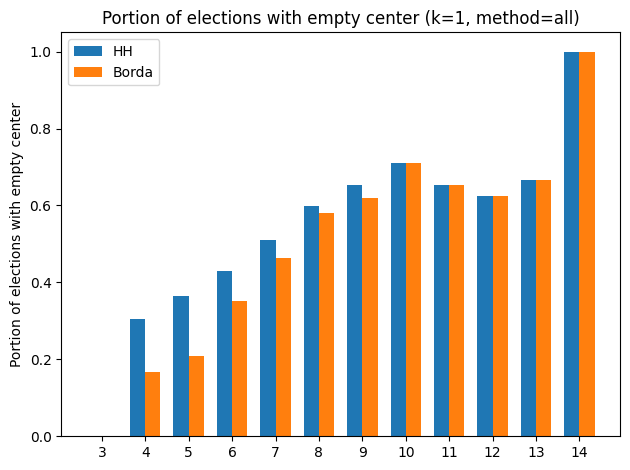

In [33]:
# for k=1, repeat the above keeping separate track for each value of num_cands.
election_counts_with_empty_centers_k1 = dict() # map (num_cands, proxy) -> count of elections with empty centers
election_counts_total_k1 = dict() # map (num_cands, proxy) -> total count of elections
for index in df.index:
    method = df['method'][index]
    proxy = df['proxy'][index]
    if method != 'all':
        continue
    centers = df['centers'][index]
    num_cands = df['num_cands'][index]
    k = df['k'][index]
    if k != 1:
        continue
    election_counts_total_k1[(num_cands, proxy)] = (
        election_counts_total_k1.get((num_cands, proxy), 0) + 1)
    if any(len(center) == 0 for center in centers):
        election_counts_with_empty_centers_k1[(num_cands, proxy)] = (
            election_counts_with_empty_centers_k1.get((num_cands, proxy), 0) + 1)
        
# plot the result as side-by-side bar bar graphs (left = HH, right = Borda) of the portion of elections with empty centers vs num_cands.
num_cands_list = sorted(list(set([key[0] for key in election_counts_total_k1.keys()])))
portion_list_HH = [] # portion of elections with empty centers for HH proxy
portion_list_Borda = [] # portion of elections with empty centers for Borda proxy
for num_cands in num_cands_list:
    portion_HH = election_counts_with_empty_centers_k1.get((num_cands, 'HH'), 0) / election_counts_total_k1.get((num_cands, 'HH'), 1)
    portion_Borda = election_counts_with_empty_centers_k1.get((num_cands, 'Borda'), 0) / election_counts_total_k1.get((num_cands, 'Borda'), 1)
    portion_list_HH.append(portion_HH)
    portion_list_Borda.append(portion_Borda)
x = np.arange(len(num_cands_list))  # the label locations
width = 0.35  # the width of the bars
fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, portion_list_HH, width, label='HH')
rects2 = ax.bar(x + width/2, portion_list_Borda, width, label='Borda')
# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Portion of elections with empty center')
ax.set_title('Portion of elections with empty center (k=1, method=all)')
ax.set_xticks(x)
ax.set_xticklabels(num_cands_list)
ax.legend()
fig.tight_layout()
plt.show() 

In [34]:
# among the elections with non-empty 'all' centers, find the portion where:
# A_equal : 'all' centers = 'cast' centers
# A_tie_cast & A_win_cast: 'all' centers were cast in election and tie/beat the 'cast' centers
#   note that A_win_cast must be zero.
# A_tie_uncast & A_win_uncast: 'all' centers were not cast in election and tie/beat the 'cast' centers.
A_equal_counts = {(proxy, k):0 for proxy in ['Borda','HH'] for k in [1,2]}
A_tie_cast_counts = {(proxy, k):0 for proxy in ['Borda','HH'] for k in [1,2]}
A_win_cast_counts = {(proxy, k):0 for proxy in ['Borda','HH'] for k in [1,2]}
A_tie_uncast_counts = {(proxy, k):0 for proxy in ['Borda','HH'] for k in [1,2]}
A_win_uncast_counts = {(proxy, k):0 for proxy in ['Borda','HH'] for k in [1,2]}
total_counts = {(proxy, k):0 for proxy in ['Borda','HH'] for k in [1,2]}

for index in df.index:
    method = df['method'][index]
    proxy = df['proxy'][index]
    if method != 'all':
        continue
    centers_all = df['centers'][index]
    num_cands = df['num_cands'][index]
    k = df['k'][index]
    if any(len(center) == 0 for center in centers_all):
        continue
    # find the cast centers for this election
    filename = df['filename'][index]
    df_sub_cast = df[(df['filename']==filename) & (df['method']=='cast') 
                     & (df['proxy']==proxy) & (df['k']==k)]
    if df_sub_cast.shape[0] == 0:
        print(f"Missing cast data for {filename}, proxy={proxy}, k={k}")
        continue
    centers_cast = df_sub_cast['centers'].values[0]
    total_counts[(proxy, k)] += 1

    # check for equality
    if set(map(tuple, centers_all)) == set(map(tuple, centers_cast)):
        A_equal_counts[(proxy, k)] += 1
        continue

    # check for tie/beat cases
    tie =  df['score'][index] == df_sub_cast['score'].values[0]
    
    # check the all centers were cast in the election
    full_filename = f"../scot-elex/{num_cands}_cands/{filename}"
    num_cands, election, cand_names, ward = csv_parse(full_filename)
    were_cast = all(tuple(center) in election.keys() for center in centers_all)
    
    if tie and were_cast:
        A_tie_cast_counts[(proxy, k)] += 1
    elif (not tie) and were_cast:
        A_win_cast_counts[(proxy, k)] += 1
    elif tie and (not were_cast):
        A_tie_uncast_counts[(proxy, k)] += 1
    else:
        A_win_uncast_counts[(proxy, k)] += 1

In [35]:
# summarize results
print("\nAmong elections with non-empty 'all' centers, summary of the portion for which the 'all' centers...")
for proxy in ['Borda','HH']:
    for k in [1,2]:
        total = total_counts[(proxy, k)]
        if total == 0:
            continue
        print(f" k={k}, proxy={proxy}:")
        print(f"\t\t ...equal the cast centers: {A_equal_counts[(proxy, k)]/total:.1%}")
        print(f"\t\t ...were cast in the election and tie the cast centers: {A_tie_cast_counts[(proxy, k)]/total:.1%}")
        #print(f"\t\t ...were cast in the election and beat the cast centers: {A_win_cast_counts[(proxy, k)]/total:.1%}")
        print(f"\t\t ...were not cast in the election and tie the cast centers: {A_tie_uncast_counts[(proxy, k)]/total:.1%}")
        print(f"\t\t ...were not cast in the election and beat the cast centers: {A_win_uncast_counts[(proxy, k)]/total:.1%}")


Among elections with non-empty 'all' centers, summary of the portion for which the 'all' centers...
 k=1, proxy=Borda:
		 ...equal the cast centers: 99.5%
		 ...were cast in the election and tie the cast centers: 0.2%
		 ...were not cast in the election and tie the cast centers: 0.2%
		 ...were not cast in the election and beat the cast centers: 0.2%
 k=2, proxy=Borda:
		 ...equal the cast centers: 99.7%
		 ...were cast in the election and tie the cast centers: 0.0%
		 ...were not cast in the election and tie the cast centers: 0.0%
		 ...were not cast in the election and beat the cast centers: 0.3%
 k=1, proxy=HH:
		 ...equal the cast centers: 100.0%
		 ...were cast in the election and tie the cast centers: 0.0%
		 ...were not cast in the election and tie the cast centers: 0.0%
		 ...were not cast in the election and beat the cast centers: 0.0%
 k=2, proxy=HH:
		 ...equal the cast centers: 99.8%
		 ...were cast in the election and tie the cast centers: 0.2%
		 ...were not cast in the 

In [53]:
# Similarly, find portions of elections with at least one empty 'coords' center.

election_counts_with_empty_centers = dict() # map (k, proxy) -> count of elections with empty centers
election_counts_total = dict() # map (k, proxy) -> total count of elections
election_names_with_empty_centers_k2 = {'Borda': [], 'HH': []} # map (proxy) -> list of election filenames

print("Portions of elections with at least one empty 'coords' center:")
print("(equivalently, at least one center in proxy space that equals the zero vector)")
for index in df.index:
    method = df['method'][index]
    proxy = df['proxy'][index]
    if method != 'coords':
        continue
    centers = df['centers'][index]
    num_cands = df['num_cands'][index]
    k = df['k'][index]
    election_counts_total[(k, proxy)] = (
        election_counts_total.get((k, proxy), 0) + 1)
    if any(center is not None and len(center) == 0 for center in centers):
        election_counts_with_empty_centers[(k, proxy)] = (
            election_counts_with_empty_centers.get((k, proxy), 0) + 1)
        if k==2:
            #print(f"\t{df['filename'][index]}, k={k}, proxy={proxy}, num_cands = {num_cands}, centers = {centers}")
            election_names_with_empty_centers_k2[proxy].append(df['filename'][index])

portions = {key: election_counts_with_empty_centers.get(key, 0) / election_counts_total[key]
            for key in election_counts_total.keys()}
for key, portion in portions.items():
    print(f"\tk={key[0]}, proxy={key[1]}: {portion:.1%} of elections have empty center")

Portions of elections with at least one empty 'coords' center:
(equivalently, at least one center in proxy space that equals the zero vector)
	k=1, proxy=Borda: 7.5% of elections have empty center
	k=1, proxy=HH: 23.7% of elections have empty center
	k=2, proxy=Borda: 1.6% of elections have empty center
	k=2, proxy=HH: 0.3% of elections have empty center


In [36]:
# add column for the size of the smaller of the clusters
smallest_cluster_sizes = []
for index in df.index:
    clustering = df['clustering'][index]
    cluster_sizes = [sum(clustering[cluster].values()) for cluster in clustering.keys()]
    smallest_cluster_sizes.append(min(cluster_sizes)/sum(cluster_sizes))
df['smallest_cluster_size'] = smallest_cluster_sizes

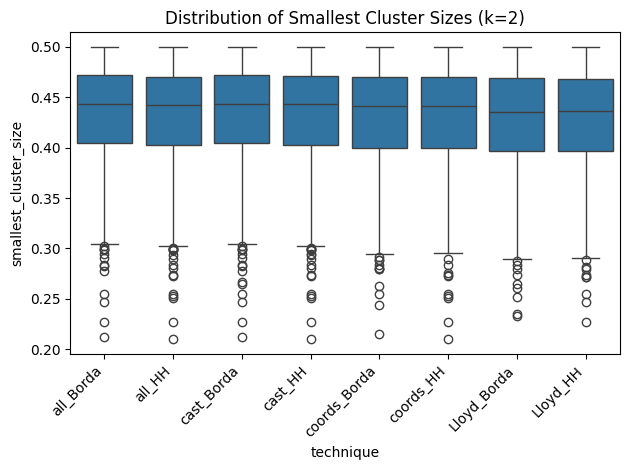

In [37]:
ax = sns.boxplot(data=df[(df['k']==2) & (df['method'].isin(['cast', 'all', 'coords', 'Lloyd']))], x='technique', y='smallest_cluster_size')
plt.setp(ax.get_xticklabels(), rotation=45, ha='right')
plt.title('Distribution of Smallest Cluster Sizes (k=2)')
plt.tight_layout()
plt.savefig('smallest_cluster_size_distribution_k2.png', dpi=300)
plt.show()

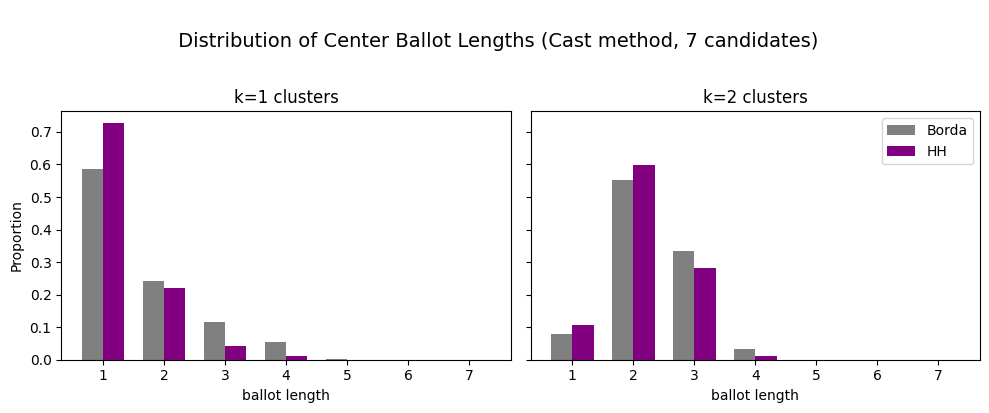

In [38]:
# find distribution of the lengths of the centers from the 'cast' method (k=1 and k=2 side-by-side)
num_cands = 7
X = np.arange(num_cands)
width = .7/2
palat = ['grey', 'purple']

fig, axes = plt.subplots(1, 2, figsize=(10, 4), sharey=True)

for ax, k_ in zip(axes, [1, 2]):
    for i, proxy in enumerate(['Borda', 'HH']):
        Y = np.zeros(num_cands)
        count = 0
        df_sub = df[(df['method'] == 'cast') & (df['proxy'] == proxy) & (df['k'] == k_) & (df['num_cands'] == num_cands)]
        for idx in df_sub.index:
            centers = df_sub['centers'][idx]
            for center in centers:
                Y[len(center) - 1] += 1
                count += 1
        if count > 0:
            Y = Y / count
        ax.bar(X + (i-.5) * width, Y, width=width, label=f"{proxy}", color=palat[i])

    ax.set_title(f'k={k_} clusters')
    ax.set_xlabel('ballot length')
    ax.set_xticks(X)
    ax.set_xticklabels(X + 1)
fig.suptitle(f'\n Distribution of Center Ballot Lengths (Cast method, {num_cands} candidates)', fontsize=14, y=1.02)
axes[0].set_ylabel('Proportion')
axes[1].legend()
plt.tight_layout()
#plt.savefig(f'center_ballot_length_distribution_{num_cands}_cands.png', dpi=300)
plt.tight_layout()
plt.show()

In [27]:
df['method'].unique()

array(['all', 'cast', 'coords', 'Lloyd', 'PAM'], dtype=object)

In [39]:
# find portion of elections for which the cast centers match the PAM centers
# when they don't, check whether the cast centers tie or score better.

match_count = {'Borda':0, 'HH':0}
unmatch_count = {'Borda':0, 'HH':0}

tie_count = {'Borda':0, 'HH':0}
PAM_win_count = {'Borda':0, 'HH':0}
cast_win_count = {'Borda':0, 'HH':0}

row_index = 0
for index in df.index:
    if df['method'][index] != 'cast':
        continue
    if df['k'][index] != 2:
        continue
    discrete_centers = df['centers'][index]
    discrete_score = df['score'][index]
    filename = df['filename'][index]
    proxy_type = df['proxy'][index]
    row_index = df[(df['filename'] == filename) & (df['technique'] == f'PAM_{proxy_type}') & (df['k'] == 2)].index[0]
    PAM_score = df['score'][row_index]
    PAM_centers = df['centers'][row_index]
    if set([tuple(x) for x in PAM_centers]) == set([tuple(x) for x in discrete_centers]):
        match_count[proxy_type] += 1
        continue
    else:
        unmatch_count[proxy_type] += 1
    
    if discrete_score == PAM_score:
        tie_count[proxy_type] += 1
        #print("TIE: ",filename, proxy_type)
    elif discrete_score < PAM_score:
        cast_win_count[proxy_type] += 1
    else:
        PAM_win_count[proxy_type] += 1
        print(proxy_type, discrete_score, PAM_score, discrete_centers, PAM_centers)

print(f"\nFor k={2}, we compare the cast centers to the PAM centers:")
print(f'\tmatch: {match_count}')
print(f'\tunmatch but tie: {tie_count}')
#print(f'PAM win: {PAM_win_count}')
print(f'\t"cast" win: {cast_win_count}')


For k=2, we compare the cast centers to the PAM centers:
	match: {'Borda': 959, 'HH': 991}
	unmatch but tie: {'Borda': 22, 'HH': 19}
	"cast" win: {'Borda': 89, 'HH': 60}


In [40]:
# determine the portion of the elections for which the continous score beats the cast score
for k in [1,2]:
    print(f"\nFor k={k}, comparing 'coords' method to 'cast' method:")
    tie_counts = {proxy:0 for proxy in ['Borda', 'HH']}
    continuous_win_counts = {proxy:0 for proxy in ['Borda', 'HH']}
    discrete_win_counts = {proxy:0 for proxy in ['Borda', 'HH']}

    for index in df.index:
        if df['method'][index] != 'coords':
            continue
        if df['k'][index] != k:
            continue
        filename = df['filename'][index]
        proxy_type = df['proxy'][index]
        continuous_score = df['score'][index]
        row_index = df[(df['filename'] == filename) & (df['technique'] == f'cast_{proxy_type}') & (df['k'] == k)].index[0]
        discrete_score = df['score'][row_index]

        if continuous_score == discrete_score:
            tie_counts[proxy_type] += 1
        elif continuous_score < discrete_score:
            continuous_win_counts[proxy_type] += 1
        else:
            discrete_win_counts[proxy_type] += 1
    print(f"\tcoords ties cast: {tie_counts}")
    print(f"\tcoords beats cast: {continuous_win_counts}")
    #print(f"\tDiscrete win counts: {discrete_win_counts}")


For k=1, comparing 'coords' method to 'cast' method:
	coords ties cast: {'Borda': 6, 'HH': 87}
	coords beats cast: {'Borda': 1064, 'HH': 983}

For k=2, comparing 'coords' method to 'cast' method:
	coords ties cast: {'Borda': 99, 'HH': 370}
	coords beats cast: {'Borda': 969, 'HH': 554}


In [39]:
#count the simple and generalized ballots for 7 candidates
counter = 0
for ballot in all_possible_ballots(7, include_empty_ballot=True, include_generalized_ballots=False):
    counter += 1 
print("number of simple ballots for 7 candidates:", counter)
counter = 0
for ballot in all_possible_ballots(7, include_empty_ballot=True, include_generalized_ballots=True):
    counter += 1 
print("number of generalized ballots for 7 candidates:", counter)

number of simple ballots for 7 candidates: 13700
number of generalized ballots for 7 candidates: 47293


In [ ]:
# For coords method, create columns for:
# 'actual_dist' = distance from center to closest proxy of an actual ballot
# 'gen_dist' = distance from center to closest proxy of a generalized ballot
# 'cast_dist' = distance from center to closest proxy of a cast ballot
# (all are lists of length 2, one per center)
num_cands = 7
df_coords = df[(df['method']=='coords') & (df['num_cands'] == num_cands)].copy()

actual_dist_list = []
gen_dist_list = []
cast_dist_list = []

print(len(df_coords))
count = 1
for index in df_coords.index:
    filename = df_coords['filename'][index]
    proxies_of_centers = df_coords['proxies_of_centers'][index]
    proxy_type = df_coords['proxy'][index]
    k = df_coords['k'][index]
    print(count, filename, proxy_type, k)
    count +=1
    df_cast = df[(df['filename']==filename) & (df['method']=='cast') & (df['proxy']==proxy_type)]
    cast_centers = df_cast['centers'].values[0]

    actual_dist = []
    gen_dist = []
    for proxy in proxies_of_centers:
        dist = Dist_to_closest_ballot(proxy, proxy_type)
        actual_dist.append(dist)
        dist = Dist_to_closest_ballot(proxy, proxy_type, include_generalized_ballots=True)
        gen_dist.append(dist)
    actual_dist_list.append(actual_dist)
    gen_dist_list.append(gen_dist)

    cast_dist = []
    for proxy in proxies_of_centers:
        closest_dist = float('inf')
        for center in cast_centers:
            if proxy_type == 'Borda':
                d = np.linalg.norm(proxy - Borda_proxy(center, num_cands=num_cands), ord=1)
            else:
                d = np.linalg.norm(proxy - HH_proxy(center, num_cands=num_cands), ord=1)
            if d < closest_dist:
                closest_dist = d
        cast_dist.append(closest_dist)
    cast_dist_list.append(cast_dist)

df_coords['actual_dist'] = actual_dist_list
df_coords['gen_dist'] = gen_dist_list
df_coords['cast_dist'] = cast_dist_list

In [ ]:
#df_coords.to_pickle('coords_centers_distances_7cands.pkl')
#df_coords = pd.read_pickle('coords_centers_distances_7cands.pkl')

Excluding elections with empty ballot centers from the distance histograms.


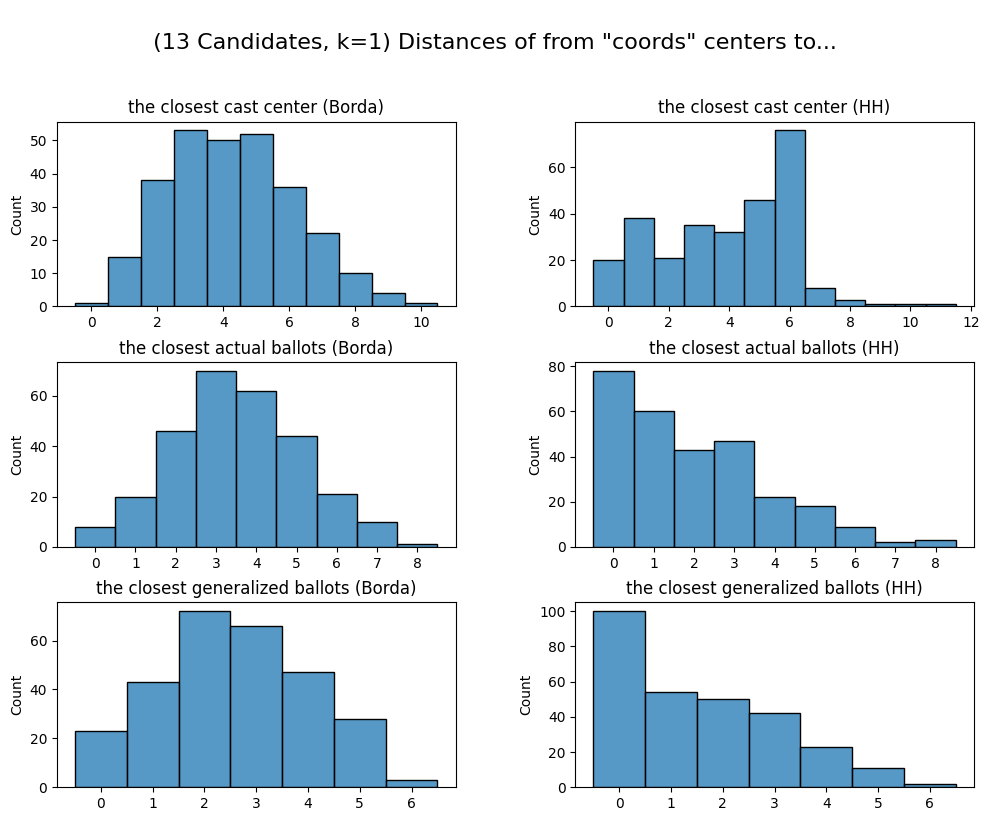

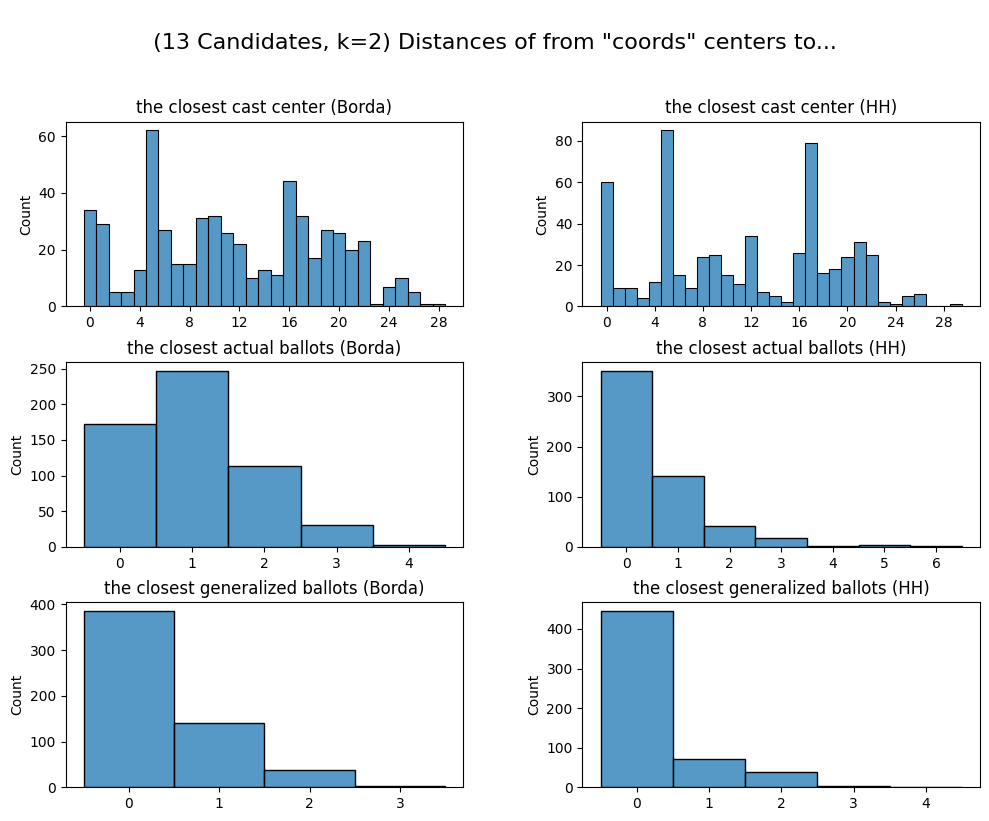

In [55]:
include_empty_ballot_centers = False
if include_empty_ballot_centers:
    print("Including elections with empty ballot centers in the distance histograms.")
else:
    print("Excluding elections with empty ballot centers from the distance histograms.")

for K in [1,2]:
    distances_to_actual_ballots = {'Borda':[], 'HH':[]}
    distances_to_gen_ballots = {'Borda':[], 'HH':[]}
    distances_to_cast_ballots = {'Borda':[], 'HH':[]}
    for index in df_coords.index:
        k = df_coords['k'][index]
        if k != K:
            continue
        if df_coords['actual_dist'][index] is None:
            continue
        proxies_of_centers = df_coords['proxies_of_centers'][index]
        if not include_empty_ballot_centers and any(center is not None and len(center) == 0 for center in proxies_of_centers):
            continue
        proxy_type = df_coords['proxy'][index]
        for d in df_coords['actual_dist'][index]:
            distances_to_actual_ballots[proxy_type].append(d)
        for d in df_coords['gen_dist'][index]:
            distances_to_gen_ballots[proxy_type].append(d)
        for d in df_coords['cast_dist'][index]:
            distances_to_cast_ballots[proxy_type].append(d)

    fig, axes = plt.subplots(3, 2, figsize=(10, 8))

    for i, proxy_type in enumerate(['Borda', 'HH']):
        sns.histplot(
            distances_to_cast_ballots[proxy_type],
            ax=axes[0, i],
            discrete=True
        )
        axes[0, i].set_title(f'the closest cast center ({proxy_type})')

    for i, proxy_type in enumerate(['Borda', 'HH']):
        sns.histplot(
            distances_to_actual_ballots[proxy_type],
            ax=axes[1, i],
            discrete=True
        )
        axes[1, i].set_title(f'the closest actual ballots ({proxy_type})')
        
    for i, proxy_type in enumerate(['Borda', 'HH']):
        sns.histplot(
            distances_to_gen_ballots[proxy_type],
            ax=axes[2, i],
            discrete=True
        )
        axes[2, i].set_title(f'the closest generalized ballots ({proxy_type})')

    # Force integer x-ticks only
    for ax in axes.flat:
        ax.xaxis.set_major_locator(MaxNLocator(integer=True))

    plt.suptitle(f'\n ({num_cands} Candidates, k={K}) Distances of from "coords" centers to... ', fontsize=16, y=1.02)
    plt.tight_layout()
    plt.subplots_adjust(hspace=0.3, wspace=0.3)
    plt.savefig(f'coords_centers_distance_to_ballots_k{K}.png', dpi=300)
    plt.show()


In [56]:
def Centers_MDS(filename, method = 'coords', proxy_type='HH', order=1, label_ballots = False):
    """
    Create a 2D MDS plot of the following points in proxy space:
    - origin (0 vector)
    - center for k=1
    - two centers for k=2
    ARGS:
    filename: str, the election filename
    method: str, one of {'coords', 'cast', 'Lloyd', 'all'}
    proxy_type: str, one of {'Borda', 'HH'}
    order: int, 1 or 2, the L^order norm to use for distance calculations
    """
    df_sub = df[(df['filename']==filename) & (df['proxy']==proxy_type) & (df['method']==method)]
    df_sub1 = df_sub[df_sub['k']==1]
    C0 = df_sub1['proxies_of_centers'].values[0][0]
    C0_ballot = df_sub1['centers'].values[0][0]
    df_sub2 = df_sub[df_sub['k']==2]
    CA,CB = df_sub2['proxies_of_centers'].values[0]
    CA_ballot, CB_ballot = df_sub2['centers'].values[0]
    proxy_dim = len(C0)
    origin = np.zeros(proxy_dim)
    points = np.array([origin, C0, CA, CB])
    labels = ['0', f'{C0_ballot}', f'{CA_ballot}', f'{CB_ballot}'] if label_ballots else ['0', 'C1', 'C2A', 'C2B']
    dist_matrix = np.zeros((4,4))
    for i in range(4):
        for j in range(4):
            dist_matrix[i,j] = np.linalg.norm(points[i]-points[j], ord=order)
    model = MDS(n_components=2, dissimilarity='precomputed', n_init = 500, metric = True)
    projections = model.fit_transform(dist_matrix)
    error = model.stress_
    X = np.array([p[0] for p in projections])
    Y = np.array([p[1] for p in projections]) 
    s = 200*np.array([1, 1, 1, 1]) # scale for point sizes
    c = ['black', 'red', 'blue', 'blue']  # colors for points
    fig, ax = plt.subplots( figsize=(3,3))
    ax.scatter(X,Y, c = c, s = s, alpha=.5)

    x_margin = (max(X) - min(X)) * 0.2  # 20% margin
    plt.xlim(min(X) - x_margin, max(X) + x_margin)
    y_margin = (max(Y) - min(Y)) * 0.2  # 20% margin
    plt.ylim(min(Y) - y_margin, max(Y) + y_margin)
    for count, label in enumerate(labels):
        ax.annotate(label, xy=(X[count], Y[count]))
    ax.grid(False)
    ax.axis('off')
    plt.show()

In [57]:
filename_list = df['filename'].unique()

angus_2017_ward4.csv, num cands = 5
    coords, Borda


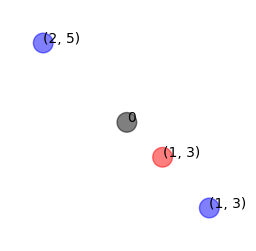

    coords, HH


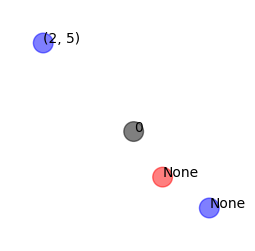

    Lloyd, Borda


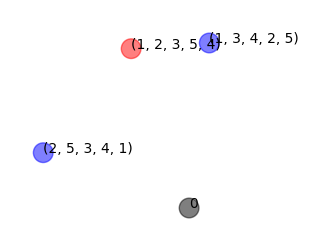

    Lloyd, HH


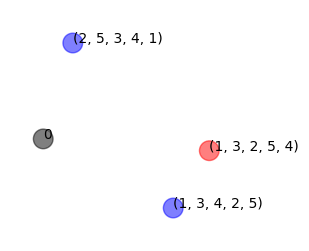

    cast, Borda


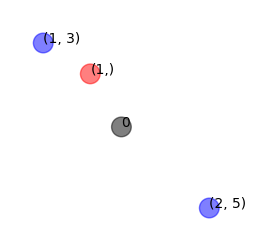

    cast, HH


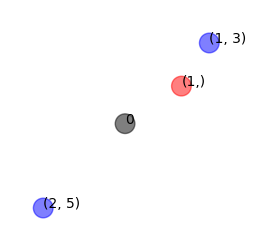

    all, Borda


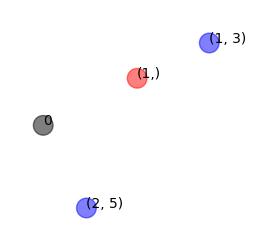

    all, HH


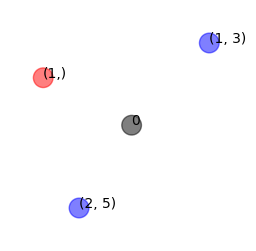

In [58]:
filename = random.choice(filename_list)
num_cands = D_num_cands[filename]
print(f"{filename}, num cands = {num_cands}")
for method in ['coords', 'Lloyd', 'cast', 'all']:
    for proxy in ['Borda', 'HH']:
        print(f"    {method}, {proxy}")
        Centers_MDS(filename, method, proxy, label_ballots=True)

sc_borders_2017_ward10.csv


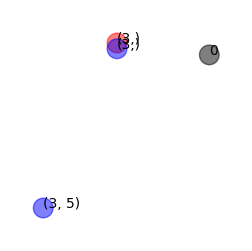

In [15]:
for _ in range(1):
    filename = random.choice(filename_list)
    print(filename)
    Centers_MDS(filename, 'coords', 'Borda', label_ballots=True)

In [17]:
Summarize_centers(filename, k=1)
Summarize_centers(filename, k=2)


 Filename: sc_borders_2017_ward10.csv, k=1
Lloyd, Borda: ~(3, 5, 6, 4, 2, 1) 
coords, Borda: =(3,) 
cast, Borda: =(3,) 
Lloyd, HH: ~(3, 5, 6, 4, 2, 1) 
coords, HH: =(3,) 
cast, HH: =(3,) 

 Filename: sc_borders_2017_ward10.csv, k=2
Lloyd, Borda: ~(5, 3, 6, 1, 2, 4)  ~(3, 4, 6, 2, 1, 5) 
coords, Borda: =(3, 5)  =(3,) 
cast, Borda: =(3, 5)  =(3,) 
Lloyd, HH: ~(3, 5, 6, 1, 2, 4)  ~(3, 4, 6, 2, 1, 5) 
coords, HH: =(3,)  =(3, 5) 
cast, HH: =(3, 5)  =(3,) 


In [47]:
# create column of df for Piotr's measurement of polarization (using Cast_HH only)

pol_list = []
for index in df_p.index:
    filename = df['filename'][index]
    num_cands = df['num_cands'][index]
    full_filename = f"../scot-elex/{num_cands}_cands/{filename}"
    num_cands, election, cand_names, ward = csv_parse(full_filename)
    num_voters = sum(election.values())
    centers = df['centers'][index]
    score2 = df['score'][index]
    
    df1 = df[(df['method']=='cast') & (df['proxy']=='HH') & (df['k']==1) & (df['filename']==filename)]
    score1 = df1['score'].values[0]
    proxy_diameter = (num_cands)*(num_cands -1)/2
    pol = (score1 - score2) / (num_voters*proxy_diameter)
    pol_list.append(pol)

df_p['polarization'] = pol_list

<Axes: xlabel='polarization', ylabel='Count'>

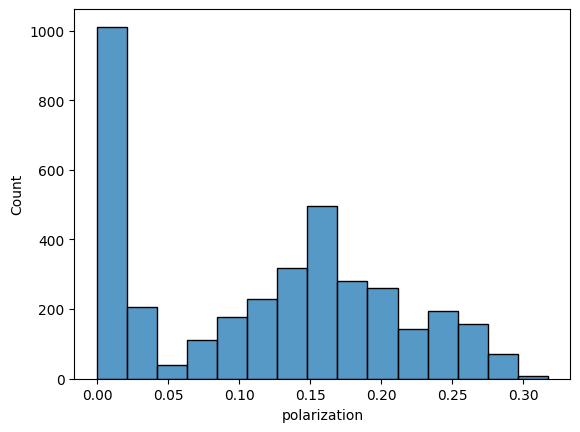

In [49]:
sns.histplot(df['polarization'])

In [50]:
# study a maximally polarized election
M = df_p['polarization'].max()
df_sub = df_p[df_p['polarization'] == M]
df_sub

,filename,num_cands,k,method,proxy,technique,centers,proxies_of_centers,score,clustering,polarization
940,perth_kinross_2022_ward7.csv,6,2,cast,HH,cast_HH,"[(1, 5, 3), (2, 6, 4)]","[[1.0, 1.0, 1.0, 1.0, 1.0, -1.0, 0.0, -1.0, 0....",11587.0,"{0: {(3, 1, 5): 50.0, (1, 5, 3, 2, 4, 6): 3.0,...",0.221087


In [51]:
filename = df_sub['filename'].values[0]
full_filename = f"../scot-elex/6_cands/{filename}"
num_cands, election, cand_names, ward = csv_parse(full_filename)

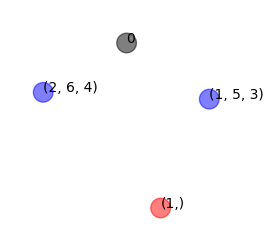

In [52]:
Centers_MDS(filename, method='cast', proxy_type='HH', label_ballots=True)

In [53]:
C = df_sub['clustering'].values[0]

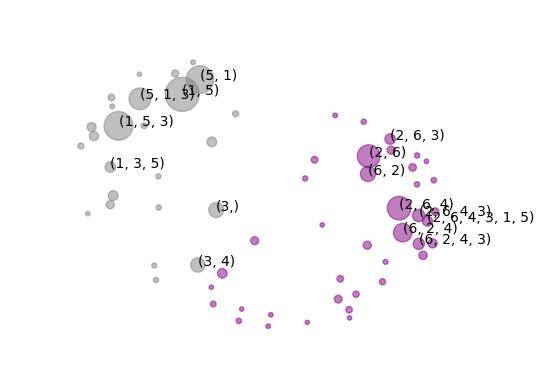

In [55]:
Ballot_MDS_plot(election, C, proxy='HH', label_threshold=50)

In [56]:
# Repeat this for a least polarized election
m = df_p['polarization'].min()
df_sub = df_p[df_p['polarization'] == m]
df_sub

,filename,num_cands,k,method,proxy,technique,centers,proxies_of_centers,score,clustering,polarization
995,sc_borders_2017_ward10.csv,6,2,cast,HH,cast_HH,"[(3, 5), (3,)]","[[0.0, -1.0, 0.0, -1.0, 0.0, -1.0, 0.0, -1.0, ...",9745.0,"{0: {(1, 3, 2, 5, 6, 4): 0.5, (1, 3, 5, 6): 1....",0.048137


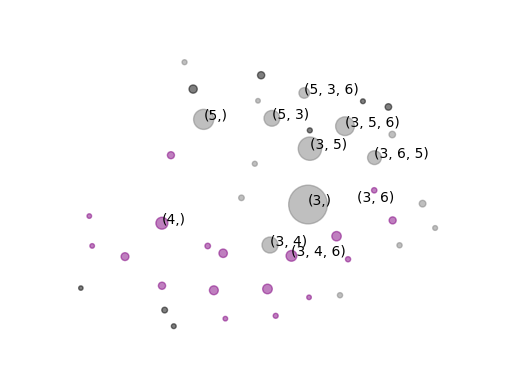

In [57]:
filename = df_sub['filename'].values[0]
full_filename = f"../scot-elex/6_cands/{filename}"
num_cands, election, cand_names, ward = csv_parse(full_filename)
Ballot_MDS_plot(election, C, proxy='HH', label_threshold=50)

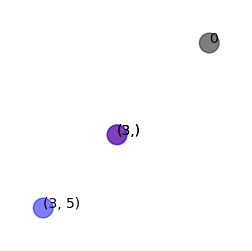

In [58]:
Centers_MDS(filename, method='cast', proxy_type='HH', label_ballots=True)

In [62]:
# add a column to df_p for summed distances
sum_dist_list = []
for index in df_p.index:
    filename = df_p['filename'][index]
    num_cands = df_p['num_cands'][index]
    center2a, center2b = df_p['centers'][index]
    df_sub = df[(df['method']=='cast') & (df['proxy']=='HH') & (df['k']==1) & (df['filename']==filename)]
    center0 = df_sub['centers'].values[0][0]
    d_ab = HH_dist(center2a, center2b, num_cands)
    d_a0 = HH_dist(center2a, center0, num_cands)
    d_b0 = HH_dist(center2b, center0, num_cands)
    sum_dist = min(d_a0 + d_b0) + d_ab
    sum_dist_list.append(sum_dist)
df_p['sum_distances'] = sum_dist_list

TypeError: 'numpy.float64' object is not iterable

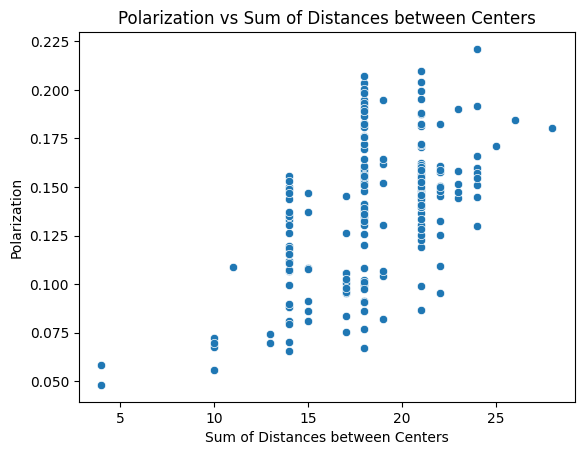

In [63]:
sns.scatterplot(data=df_p, x='sum_distances', y='polarization')
plt.title('Polarization vs Sum of Distances between Centers')
plt.xlabel('Sum of Distances between Centers')
plt.ylabel('Polarization')
plt.show()

In [64]:
df.columns

Index(['filename', 'num_cands', 'k', 'method', 'proxy', 'technique', 'centers',
       'proxies_of_centers', 'score', 'clustering', 'polarization'],
      dtype='object')

In [5]:
filename_list = df['filename'].unique()

In [6]:
# In what portion of elections do the 'cast' centers with Borda and HH proxies match exactly?
for k in [1,2]:
    match_count = 0
    total_count = 0
    for filename in filename_list:
        df_sub_Borda = df[(df['filename']==filename) & (df['method']=='cast') & (df['proxy']=='Borda') & (df['k']==k)]
        df_sub_HH = df[(df['filename']==filename) & (df['method']=='cast') & (df['proxy']=='HH') & (df['k']==k)]
        if df_sub_Borda.shape[0] == 0 or df_sub_HH.shape[0] == 0:
            print(f"Missing data for {filename}, k={k}")
            continue
        centers_Borda = df_sub_Borda['centers'].values[0]
        centers_HH = df_sub_HH['centers'].values[0]
        total_count += 1
        if set(map(tuple, centers_Borda)) == set(map(tuple, centers_HH)):
            match_count += 1
    print(f"\nFor k={k}, portion of elections where cast centers match exactly for Borda and HH: {match_count}/{total_count} = {match_count/total_count:.1%}")


For k=1, portion of elections where cast centers match exactly for Borda and HH: 798/1070 = 74.6%

For k=2, portion of elections where cast centers match exactly for Borda and HH: 786/1070 = 73.5%
